In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")
import time


INFO:root:test


In [2]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
xclbin='/data/craco/ban115/builds/binary_container_1_10688715.xclbin'
#xclbin='/data/craco/ban115/builds/binary_container_01482863.xclbin'
alloc_device_only=True

In [3]:
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, max_ndm=1024, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [4]:
device = pyxrt.device(1)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)


In [5]:
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 512 --ndout 186")

INFO:root:Opening file /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits
INFO:root:making Plan values=Namespace(boxcar_weight='sum', cell=None, fdmt_scale=1.0, fft_scale=10.0, max_ndm=1024, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, threshold=3, uv='uv_data', verbose=False)
INFO:root:Nbl=190 Fch1=735499993.944000 foff=1000000.047500 nchan=256 lambdamin=0.302877 uvmax=(2914.412072271962, 3548.709136210335) max baseline=(0.882709355209954, 1.0748235581559127) resolution=[70.77407077 58.12389754]arcsec uvcell=[33.70193846 27.67804645] arcsec uvcell= (23.90728653035594, 29.110504632975406) lambda FoV=[2.39658229 1.96821664] deg oversampled=(2.1, 2.1)
INFO:root:Got Ncells=3838 uvcells


parsing values --ndm 512 --ndout 186


INFO:root:FDMT plan has ntotal=5272 of 659 runs with packing efficiency 0.727997. Grid read requires efficiency of > 0.643555 of NUV=8192. History size square=753094656 minimal=163316296 =2 256MB HBM banks
INFO:root:FDMT zero cell is (658, 2)=5266
INFO:root:Saving uvgrid.split shape=(5245, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:root:Got 3388 unique UV coords. Upper=True
INFO:root:Need to write 212 groups of 16 register to pad function
INFO:root:Got 3367 unique UV coords. Upper=False
INFO:root:Need to write 211 groups of 16 register to pad function
INFO:root:Got 5362 upper grid instructions
INFO:root:Saving gridlut.upper shape=(5362, 5) type=int32 to uv_data.gridlut.upper.txt header=target_slot, uvidx, shift_flag, upix, vpix
INFO:root:Got 5324 lower grid instructions
INFO:root:Saving gridlut.lower shape=(5324, 5) type=int32 to uv_data.gridlut.lower.txt h

In [6]:
print(plan.ndout)

186


In [7]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

INFO:craco.search_pipeline:2636 2681 2662
INFO:craco.search_pipeline:(180214,)


Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups


INFO:craco.search_pipeline:lut.shape (180214,)
INFO:craco.search_pipeline:nuv 5272
INFO:craco.search_pipeline:Allocating grid LUTs
INFO:craco.search_pipeline:Allocating FDMT Input
INFO:craco.search_pipeline:5272
INFO:craco.search_pipeline:256
INFO:craco.search_pipeline:32
INFO:craco.search_pipeline:8
INFO:craco.search_pipeline:659
INFO:craco.search_pipeline:186
INFO:craco.search_pipeline:FDMT input buffer size 164.75 MB
INFO:craco.search_pipeline:Allocating FDMT history


Kernel fft2d:fft2d_4 has groups
Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allocated 360428 bytes flags=flags.normal groupid=20 address=0x140000000
Allocated 360428 bytes flags=flags.normal groupid=21 address=0x150000000
Allocated 172752896 bytes flags=flags.normal groupid=52 address=0x90000000
Allocated 268435456 bytes flags=flags.normal groupid=53 address=0xa0000000


INFO:craco.search_pipeline:Allocating mainbuf
INFO:craco.search_pipeline:FDMT output buffer size 10.286819458007812 GB
INFO:root:Mainbuf shape is (659, 186, 11, 256, 8, 2) breaking into 8 buffers of [83, 186, 11, 256, 8, 2]


Allocated 653728 bytes flags=flags.normal groupid=14 address=0xe0000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4000000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4052eb4000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40a5d68000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40f8c1c000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x414bad0000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x419e984000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x41f1838000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x42446ec000


INFO:craco.search_pipeline:Allocating ddreader_lut
INFO:craco.search_pipeline:Allocating boxcar_history


Allocated 8192 bytes flags=flags.normal groupid=15 address=0xf0000000
Allocated 1073741824 bytes flags=flags.normal groupid=54 address=0x0


INFO:craco.search_pipeline:Allocating candidates


Boxcar history (1024, 8, 256, 256) 1073741824 2
Allocated 1048576 bytes flags=flags.normal groupid=4 address=0x40000000


In [8]:
p.fdmtcu.krnl.read_register(0x00)

4

In [9]:
# check clearing buffers a lot doesn't lockup
print(values)
for i in range(100):
    print('Clearing', i)
#    p.clear_buffers(values)
    p.run(i % 11, values).wait()
    #time.sleep(0.1)
    

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, max_ndm=1024, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')
Clearing 0


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 1



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 2


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 3


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 4


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 5


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 6


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 7


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 8



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 9


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 10


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 11


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 12


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 13


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 14


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 15


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 16


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 17


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 18


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 19


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 20



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 21


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 22


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 23


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 24


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 25


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 26


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 27


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 28


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 29


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 30


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 31


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 32


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 33


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 34


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 35


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 36


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 37


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 38


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 39


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 40


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 41


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 42


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 43


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 44


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 45


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 46


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 47


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 48


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 49



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 50


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 51


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 52


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 53


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 54


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 55


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 56


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 57


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 58


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 59


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 60


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 61


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 62


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 63


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 64


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 65


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 66


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 67


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 68


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 69


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 70


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 71


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 72


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 73


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 74


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 75



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 76


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 77



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 78



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 79


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 80


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 81


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 82



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 83



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 84


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete

Clearing 85



INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 86


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 87


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 88


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 89


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 90


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=3 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 91


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=4 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 92


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=5 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt


Clearing 93


INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=6 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 94


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=7 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 95


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=8 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 96


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=9 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 97


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=10 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 98


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


Clearing 99


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


In [10]:
p.clear_buffers(values)
# dmamp = 32 gives SNR=14.2
dmamp = 32
t0 = 0

# put in a value for a single time and DM
for b in p.all_mainbufs:
    print(b.shape)
    #b.nparr[:] = dmamp #np.random.randn(*b.nparr.shape)
    #b.nparr[:] = dmamp
    b.nparr[:,:,:,t0,:,0] = dmamp
    b.copy_to_device() 

INFO:root:Clearing mainbuf data NBLK=11
INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=65

[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]


In [11]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)
347787264


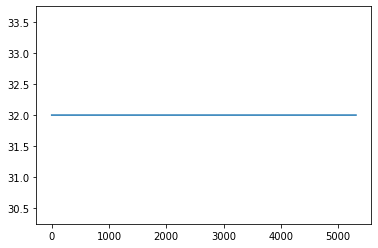

In [12]:
print(mainbuf.shape)
plot(mainbuf[:,0,0,t0,:,0].flat)
assert np.all(mainbuf[:,0,0,t0,:,0] == dmamp)
assert np.all(mainbuf[:,1:,1:,:t0,:,1] == 0)
assert np.all(mainbuf[:,1:,1:,:t0+1,:,1] == 0)
print(mainbuf.sum())

In [13]:
values.run_fdmt = False
values.run_image = True
values.threshold = 3
print(values)
p.run(0, values).wait()

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=192 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running


Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, max_ndm=1024, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=False, run_image=True, show=False, show_candidate_grid=None, threshold=3, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


INFO:craco.search_pipeline:Waiting for 10 starts


In [14]:
cands = p.get_candidates()
print(f'Got {len(cands)} candidates')
if len(cands) == 0: # are you sure?
    p.candidates.copy_from_device()
    print(p.candidates.nparr)
    
print_candidates(cands, 256, 0)

Got 7799 candidates
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
3.0	162	129	0		1	0	0
34.9	127	129	0		0	0	0
5.6	138	130	0		0	0	0
5.2	122	130	0		0	0	0
8.0	135	131	0		1	0	0
3.3	105	131	0		0	0	0
5.0	120	131	0		1	0	0
5.2	134	132	1		1	0	0
7.9	124	132	0		0	0	0
8.0	133	133	0		0	0	0
3.5	102	133	0		1	0	0
4.5	123	133	0		0	0	0
6.8	134	134	0		0	0	0
5.2	117	134	0		1	0	0
8.0	131	135	0		1	0	0
3.6	147	135	0		0	0	0
5.6	116	135	0		1	0	0
6.5	136	136	1		1	0	0
3.9	110	136	0		0	0	0
5.2	126	136	1		1	0	0
5.0	131	137	0		0	0	0
3.4	179	137	0		0	0	0
3.3	111	137	1		1	0	0
4.5	118	137	0		1	0	0
5.6	130	138	0		0	0	0
3.4	178	138	1		1	0	0
3.9	108	138	1		1	0	0
4.8	117	138	0		1	0	0
4.5	131	139	0		0	0	0
3.5	181	139	0		1	0	0
3.8	107	139	0		1	0	0
4.6	121	139	0		0	0	0
4.4	122	140	1		1	0	0
3.4	101	141	0		0	0	0
6.1	121	141	1		1	0	0
4.3	100	142	0		0	0	0
6.6	120	142	1		1	0	0
3.7	99	143	1		1	0	0
3.9	119	143	0		0	0	0
3.8	96	144	0		0	0	0
3.1	71	145	0		0	0	0
4.7	95	145	1		

4.3	129	127	0		0	150	0
8.8	128	128	0		136	150	0
3.2	127	129	0		136	150	0
3.2	129	127	0		136	150	0
8.5	128	128	0		0	151	0
4.3	127	129	0		0	151	0
4.3	129	127	0		0	151	0
8.5	128	128	0		0	152	0
4.3	127	129	0		0	152	0
4.3	129	127	0		0	152	0
8.5	128	128	0		0	153	0
4.3	127	129	0		0	153	0
4.3	129	127	0		0	153	0
5.4	128	128	0		152	153	0
8.5	128	128	0		0	154	0
4.3	127	129	0		0	154	0
4.3	129	127	0		0	154	0
9.0	128	128	0		112	154	0
3.5	127	129	0		112	154	0
3.5	129	127	0		112	154	0
8.9	128	128	0		128	154	0
3.1	127	129	0		128	154	0
3.1	129	127	0		128	154	0
8.5	128	128	0		0	155	0
4.3	127	129	0		0	155	0
4.3	129	127	0		0	155	0
8.7	128	128	0		128	155	0
3.1	127	129	0		128	155	0
3.1	129	127	0		128	155	0
8.5	128	128	0		0	156	0
4.3	127	129	0		0	156	0
4.3	129	127	0		0	156	0
9.1	128	128	0		96	156	0
3.9	127	129	0		96	156	0
3.9	129	127	0		96	156	0
8.5	128	128	0		0	157	0
4.3	127	129	0		0	157	0
4.3	129	127	0		0	157	0
9.0	128	128	0		96	157	0
3.8	127	129	0		96	157	0
3.8	129	127	0		96	157	0
8.5	128	128	0		0	158	0
4.

8.6	128	128	0		240	309	0
3.0	127	129	0		240	309	0
3.0	129	127	0		240	309	0
8.6	128	128	0		248	309	0
3.0	127	129	0		248	309	0
3.0	129	127	0		248	309	0
12.1	128	128	1		1	310	0
5.2	127	129	1		1	310	0
5.2	129	127	1		1	310	0
8.6	128	128	0		9	310	0
3.0	127	129	0		9	310	0
3.0	129	127	0		9	310	0
8.6	128	128	0		17	310	0
3.0	127	129	0		17	310	0
3.0	129	127	0		17	310	0
8.6	128	128	0		25	310	0
3.0	127	129	0		25	310	0
3.0	129	127	0		25	310	0
8.6	128	128	0		33	310	0
3.0	127	129	0		33	310	0
3.0	129	127	0		33	310	0
8.6	128	128	0		41	310	0
3.0	127	129	0		41	310	0
3.0	129	127	0		41	310	0
8.6	128	128	0		49	310	0
3.0	127	129	0		49	310	0
3.0	129	127	0		49	310	0
8.6	128	128	0		57	310	0
3.0	127	129	0		57	310	0
3.0	129	127	0		57	310	0
8.6	128	128	0		65	310	0
3.0	127	129	0		65	310	0
3.0	129	127	0		65	310	0
8.6	128	128	0		73	310	0
3.0	127	129	0		73	310	0
3.0	129	127	0		73	310	0
8.6	128	128	0		81	310	0
3.0	127	129	0		81	310	0
3.0	129	127	0		81	310	0
8.6	128	128	0		89	310	0
3.0	127	129	0		89	310	0
3.0	129	127	0		

8.7	128	128	0		48	353	0
3.4	127	129	0		48	353	0
3.4	129	127	0		48	353	0
8.7	128	128	0		56	353	0
3.4	127	129	0		56	353	0
3.4	129	127	0		56	353	0
8.7	128	128	0		64	353	0
3.4	127	129	0		64	353	0
3.4	129	127	0		64	353	0
8.7	128	128	0		72	353	0
3.4	127	129	0		72	353	0
3.4	129	127	0		72	353	0
8.7	128	128	0		80	353	0
3.4	127	129	0		80	353	0
3.4	129	127	0		80	353	0
8.7	128	128	0		88	353	0
3.4	127	129	0		88	353	0
3.4	129	127	0		88	353	0
8.7	128	128	0		96	353	0
3.4	127	129	0		96	353	0
3.4	129	127	0		96	353	0
8.7	128	128	0		104	353	0
3.4	127	129	0		104	353	0
3.4	129	127	0		104	353	0
8.7	128	128	0		112	353	0
3.4	127	129	0		112	353	0
3.4	129	127	0		112	353	0
8.7	128	128	0		120	353	0
3.4	127	129	0		120	353	0
3.4	129	127	0		120	353	0
9.0	128	128	0		128	353	0
3.3	127	129	0		128	353	0
3.3	129	127	0		128	353	0
8.7	128	128	0		136	353	0
3.4	127	129	0		136	353	0
3.4	129	127	0		136	353	0
8.7	128	128	0		144	353	0
3.4	127	129	0		144	353	0
3.4	129	127	0		144	353	0
8.7	128	128	0		152	353	0
3.4	127	129	0		152	35

3.8	129	127	0		98	421	0
9.0	128	128	0		106	421	0
3.8	127	129	0		106	421	0
3.8	129	127	0		106	421	0
9.0	128	128	0		114	421	0
3.8	127	129	0		114	421	0
3.8	129	127	0		114	421	0
9.0	128	128	0		122	421	0
3.8	127	129	0		122	421	0
3.8	129	127	0		122	421	0
9.0	128	128	0		130	421	0
3.8	127	129	0		130	421	0
3.8	129	127	0		130	421	0
9.0	128	128	0		138	421	0
3.8	127	129	0		138	421	0
3.8	129	127	0		138	421	0
9.0	128	128	0		146	421	0
3.8	127	129	0		146	421	0
3.8	129	127	0		146	421	0
9.0	128	128	0		154	421	0
3.8	127	129	0		154	421	0
3.8	129	127	0		154	421	0
9.0	128	128	0		162	421	0
3.8	127	129	0		162	421	0
3.8	129	127	0		162	421	0
9.0	128	128	0		170	421	0
3.8	127	129	0		170	421	0
3.8	129	127	0		170	421	0
9.0	128	128	0		178	421	0
3.8	127	129	0		178	421	0
3.8	129	127	0		178	421	0
9.0	128	128	0		186	421	0
3.8	127	129	0		186	421	0
3.8	129	127	0		186	421	0
9.0	128	128	0		194	421	0
3.8	127	129	0		194	421	0
3.8	129	127	0		194	421	0
9.0	128	128	0		202	421	0
3.8	127	129	0		202	421	0
3.8	129	127	0		202	421	0
9

In [15]:
print(cands)
cands = cands[cands['dm'] == 0] # DM 0 adn 1 are repeated, I think.

[(5342,     0, 0,   0,   0) (1052,   255, 0,   1,   0)
 ( 734,   257, 1,   1,   0) ... ( 545,     0, 0, 248, 511)
 ( 244,   511, 0, 248, 511) ( 244, 65281, 0, 248, 511)]


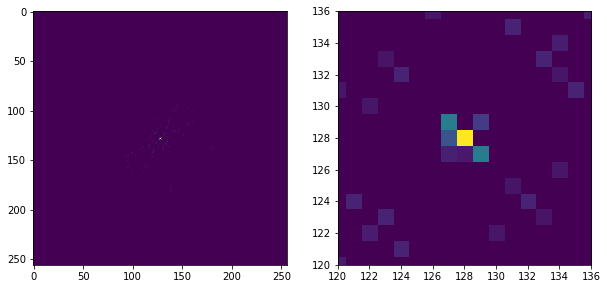

In [16]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

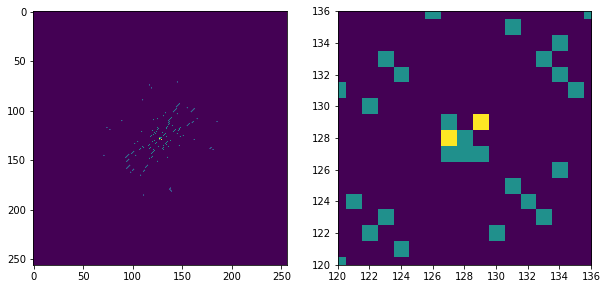

In [17]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

# Check DM0 for trange makes sense

In [18]:
all_cands = []
for t0 in range(16):
    p.clear_buffers(values)
    # dmamp = 32 gives SNR=14.2
    dmamp = 32
    print('t0', t0)

    # put in a value for a single time and DM
    for b in p.all_mainbufs:
        b.nparr[:] = 0
        b.nparr[:,:,:,t0,:,0] = dmamp
        b.copy_to_device()

    values.run_fdmt = False
    values.run_image = True
    values.threshold = 10
    p.run(0, values).wait()
    cands = p.get_candidates().copy()
    all_cands.append(cands)
    c0 = cands[0]
    print(c0)
    #assert c0['upix'] == 128
    #assert c0['vpix'] == 128
    #assert c0['boxc_width'] == 0
    #assert c0['time'] == t0
    #assert c0['dm'] == 0
    print_candidates(cands, 256, 0)

    

INFO:root:Clearing mainbuf data NBLK=11
INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=192 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=192 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=192 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candida

t0 0


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 0, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
34.9	127	129	0		0	0	0
34.9	129	127	0		0	0	0
58.7	128	128	1		1	1	0
24.6	127	129	1		1	1	0
24.5	129	127	1		1	1	0
15.3	128	128	7		8	1	0
47.2	128	128	4		4	2	0
19.7	127	129	2		2	2	0
19.7	129	127	2		2	2	0
30.3	128	128	7		8	2	0
11.4	127	129	7		8	2	0
11.6	129	127	7		8	2	0
52.0	128	128	5		5	3	0
21.0	127	129	5		5	3	0
20.8	129	127	5		5	3	0
40.6	128	128	7		8	3	0
16.0	127	129	7		8	3	0
15.9	129	127	7		8	3	0
49.5	128	128	5		5	4	0
20.3	127	129	5		5	4	0
20.4	129	127	5		5	4	0
38.5	128	128	7		8	4	0
15.4	127	129	7		8	4	0
15.5	129	127	7		8	4	0
46.6	128	128	3		5	5	0
19.4	127	129	5		5	5	0
19.3	129	127	5		5	5	0
35.5	128	128	7		8	5	0
14.6	127	129	7		8	5	0
14.6	129	127	7		8	5	0
40.6	128	128	1		5	6	0
16.9	127	129	5		5	6	0
16.9	129	127	5		5	6	0
32.1	128	128	7		8	6	0
13.2	127	129	7		8	6	0
13.3	129	127	7		8	6	0
36.5	128	128	6		6	7	0
15.5	127	129	6		6	7	0
15.5	129	127	6		6	7	0
31.9	128	128	7		

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 1


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 1, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		1	0	0
16.4	128	129	0		0	0	0
34.9	127	129	0		1	0	0
34.9	129	127	0		1	0	0
11.5	127	127	1		1	0	0
28.7	128	128	7		8	0	0
12.0	127	129	7		8	0	0
12.0	129	127	7		8	0	0
58.7	128	128	1		2	1	0
24.6	127	129	1		2	1	0
24.6	129	127	1		2	1	0
28.7	128	128	7		8	1	0
12.0	127	129	7		8	1	0
12.0	129	127	7		8	1	0
47.2	128	128	4		5	2	0
19.7	127	129	2		3	2	0
19.6	129	127	2		3	2	0
37.1	128	128	7		8	2	0
15.1	127	129	7		8	2	0
14.9	129	127	7		8	2	0
52.0	128	128	5		6	3	0
20.9	127	129	5		6	3	0
21.0	129	127	5		6	3	0
44.3	128	128	6		8	3	0
17.6	127	129	7		8	3	0
17.8	129	127	7		8	3	0
49.5	128	128	5		6	4	0
20.4	127	129	5		6	4	0
20.3	129	127	5		6	4	0
42.0	128	128	6		8	4	0
17.3	127	129	7		8	4	0
17.2	129	127	7		8	4	0
46.6	128	128	3		6	5	0
19.4	127	129	5		6	5	0
19.4	129	127	5		6	5	0
38.8	128	128	7		8	5	0
16.4	127	129	7		8	5	0
16.4	129	127	7		8	5	0
40.6	128	128	1		6	6	0
16.9	127	129	5		6	6	0
16.9	129	127	5		6	6	0
35.5	128	128	7		8	6	0
15.0	127	129	7		

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 2


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 2, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		2	0	0
16.4	127	128	0		3	0	0
11.5	129	129	1		3	0	0
34.9	127	129	0		2	0	0
34.9	129	127	0		2	0	0
31.3	128	128	6		8	0	0
13.1	127	129	6		8	0	0
13.1	129	127	6		8	0	0
58.7	128	128	1		3	1	0
24.6	127	129	1		3	1	0
24.5	129	127	1		3	1	0
31.3	128	128	6		8	1	0
13.1	127	129	6		8	1	0
13.1	129	127	6		8	1	0
41.5	128	128	1		3	2	0
18.5	127	129	1		3	2	0
18.5	129	127	1		3	2	0
31.3	128	128	6		8	2	0
13.1	127	129	6		8	2	0
13.1	129	127	6		8	2	0
33.9	128	128	5		7	3	0
14.2	127	129	5		7	3	0
14.2	129	127	5		7	3	0
31.3	128	128	6		8	3	0
13.1	127	129	6		8	3	0
13.1	129	127	6		8	3	0
37.8	128	128	1		7	4	0
14.3	127	129	1		7	4	0
14.4	129	127	1		7	4	0
31.3	128	128	6		8	4	0
13.1	127	129	6		8	4	0
13.1	129	127	6		8	4	0
44.7	128	128	1		7	5	0
17.5	127	129	1		7	5	0
17.4	129	127	1		7	5	0
35.8	128	128	2		8	5	0
14.0	127	129	2		8	5	0
13.9	129	127	2		8	5	0
40.6	128	128	1		7	6	0
16.0	127	129	1		7	6	0
16.0	129	127	1		7	6	0
35.8	128	128	2		8	6	0
14.0	127	129	2		

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 3


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 3, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		3	0	0
16.4	128	129	0		2	0	0
34.9	127	129	0		3	0	0
34.9	129	127	0		3	0	0
11.5	127	127	1		3	0	0
33.9	128	128	5		8	0	0
14.2	127	129	5		8	0	0
14.2	129	127	5		8	0	0
58.7	128	128	1		4	1	0
24.6	127	129	1		4	1	0
24.6	129	127	1		4	1	0
33.9	128	128	5		8	1	0
14.2	127	129	5		8	1	0
14.2	129	127	5		8	1	0
41.5	128	128	1		4	2	0
18.5	127	129	1		4	2	0
18.5	129	127	1		4	2	0
33.9	128	128	5		8	2	0
14.2	127	129	5		8	2	0
14.2	129	127	5		8	2	0
29.8	128	128	4		7	3	0
13.3	127	129	0		4	3	0
13.3	129	127	0		4	3	0
27.6	128	128	5		8	3	0
12.0	127	129	5		8	3	0
12.0	129	127	5		8	3	0
34.8	128	128	0		7	4	0
13.5	127	129	0		7	4	0
13.5	129	127	0		7	4	0
26.2	128	128	5		8	4	0
11.4	127	129	5		8	4	0
11.4	129	127	5		8	4	0
37.9	128	128	0		7	5	0
15.2	127	129	0		7	5	0
15.2	129	127	0		7	5	0
37.4	128	128	1		8	5	0
14.4	127	129	1		8	5	0
14.4	129	127	1		8	5	0
29.3	128	128	0		7	6	0
12.0	127	129	0		7	6	0
12.0	129	127	0		7	6	0
33.7	128	128	1		8	6	0
13.2	127	129	1		

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 4


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 4, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		4	0	0
16.4	127	128	0		5	0	0
11.5	129	129	1		5	0	0
34.9	127	129	0		4	0	0
34.9	129	127	0		4	0	0
36.5	128	128	4		8	0	0
15.2	127	129	4		8	0	0
15.3	129	127	4		8	0	0
58.7	128	128	1		5	1	0
24.6	127	129	1		5	1	0
24.5	129	127	1		5	1	0
36.5	128	128	4		8	1	0
15.3	127	129	4		8	1	0
15.2	129	127	4		8	1	0
41.5	128	128	1		5	2	0
18.5	127	129	1		5	2	0
18.5	129	127	1		5	2	0
25.8	128	128	4		8	2	0
11.5	127	129	4		8	2	0
11.5	129	127	4		8	2	0
29.1	128	128	0		5	3	0
13.3	127	129	0		5	3	0
13.3	129	127	0		5	3	0
17.0	128	128	4		8	3	0
20.9	128	128	1		5	4	0
10.2	127	129	1		5	4	0
10.2	129	127	1		5	4	0
19.7	128	128	4		8	4	0
13.9	128	128	1		5	5	0
23.9	128	128	1		9	5	0
13.9	128	128	1		5	6	0
26.8	128	128	1		9	6	0
13.8	128	128	1		5	7	0
22.2	128	128	3		11	7	0
11.7	128	128	7		16	7	0
13.4	128	128	1		5	8	0
24.2	128	128	3		11	8	0
15.1	128	128	7		16	8	0
21.6	128	128	2		12	9	0
14.4	128	128	6		16	9	0
19.2	128	128	3		12	10	0
13.2	128	128	7		16	10	0
17.1	1

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 5


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 5, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		5	0	0
16.4	128	129	0		4	0	0
34.9	127	129	0		5	0	0
34.9	129	127	0		5	0	0
11.5	127	127	1		5	0	0
41.7	128	128	3		8	0	0
17.5	127	129	3		8	0	0
17.5	129	127	3		8	0	0
58.7	128	128	1		6	1	0
24.6	127	129	1		6	1	0
24.6	129	127	1		6	1	0
41.7	128	128	3		8	1	0
17.4	127	129	3		8	1	0
17.5	129	127	3		8	1	0
41.5	128	128	1		6	2	0
18.5	127	129	1		6	2	0
18.5	129	127	1		6	2	0
29.5	128	128	3		8	2	0
13.2	127	129	3		8	2	0
13.2	129	127	3		8	2	0
29.1	128	128	0		6	3	0
13.3	127	129	0		6	3	0
13.3	129	127	0		6	3	0
27.2	128	128	3		8	3	0
11.9	127	129	3		8	3	0
11.9	129	127	3		8	3	0
20.9	128	128	1		6	4	0
10.2	127	129	1		6	4	0
10.2	129	127	1		6	4	0
28.0	128	128	4		9	4	0
11.8	127	129	4		9	4	0
11.7	129	127	4		9	4	0
13.9	128	128	1		6	5	0
26.1	128	128	5		10	5	0
10.9	127	129	5		10	5	0
10.9	129	127	5		10	5	0
11.7	128	128	7		16	5	0
13.9	128	128	1		6	6	0
27.6	128	128	6		11	6	0
11.6	127	129	5		10	6	0
11.5	129	127	5		10	6	0
15.1	128	128	7		16	6	0
13.8	128

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 6


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 6, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		6	0	0
16.4	127	128	0		7	0	0
11.5	129	129	1		7	0	0
34.9	127	129	0		6	0	0
34.9	129	127	0		6	0	0
46.9	128	128	2		8	0	0
11.5	127	128	1		8	0	0
19.6	127	129	2		8	0	0
19.7	129	127	2		8	0	0
58.7	128	128	1		7	1	0
24.6	127	129	1		7	1	0
24.5	129	127	1		7	1	0
46.9	128	128	2		8	1	0
19.7	127	129	2		8	1	0
19.6	129	127	2		8	1	0
41.5	128	128	1		7	2	0
18.5	127	129	1		7	2	0
18.5	129	127	1		7	2	0
46.9	128	128	2		8	2	0
19.7	127	129	2		8	2	0
19.7	129	127	2		8	2	0
29.1	128	128	0		7	3	0
13.3	127	129	0		7	3	0
13.3	129	127	0		7	3	0
41.7	128	128	3		9	3	0
17.5	127	129	3		9	3	0
17.4	129	127	3		9	3	0
20.9	128	128	1		7	4	0
10.2	127	129	1		7	4	0
10.2	129	127	1		7	4	0
36.8	128	128	3		10	4	0
15.3	127	129	4		10	4	0
15.3	129	127	4		10	4	0
11.8	128	128	7		16	4	0
13.9	128	128	1		7	5	0
33.9	128	128	5		11	5	0
14.2	127	129	5		11	5	0
14.2	129	127	5		11	5	0
15.3	128	128	7		16	5	0
13.9	128	128	1		7	6	0
31.5	128	128	5		11	6	0
13.4	127	129	5		11	6	0
13.4	1

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 7


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 7, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		7	0	0
16.4	128	129	0		6	0	0
34.9	127	129	0		7	0	0
34.9	129	127	0		7	0	0
11.5	127	127	1		7	0	0
58.7	128	128	1		8	0	0
24.6	127	129	1		8	0	0
24.6	129	127	1		8	0	0
39.0	128	128	0		7	1	0
18.4	127	129	0		7	1	0
18.4	129	127	0		7	1	0
58.7	128	128	1		8	1	0
24.6	127	129	1		8	1	0
24.6	129	127	1		8	1	0
19.8	128	128	0		7	2	0
10.1	127	129	0		7	2	0
10.1	129	127	0		7	2	0
46.9	128	128	2		9	2	0
19.7	127	129	2		9	2	0
19.6	129	127	2		9	2	0
41.7	128	128	3		10	3	0
17.5	127	129	3		10	3	0
17.5	129	127	3		10	3	0
15.3	128	128	7		16	3	0
36.8	128	128	3		11	4	0
15.3	127	129	4		11	4	0
15.2	129	127	4		11	4	0
18.5	128	128	7		16	4	0
33.9	128	128	5		12	5	0
14.2	127	129	5		12	5	0
14.2	129	127	5		12	5	0
21.9	128	128	7		16	5	0
31.5	128	128	5		12	6	0
13.4	127	129	5		12	6	0
13.3	129	127	5		12	6	0
21.8	128	128	7		16	6	0
29.2	128	128	6		13	7	0
12.4	127	129	6		13	7	0
12.4	129	127	6		13	7	0
21.9	128	128	7		16	7	0
26.8	128	128	7		14	8	0
11.4	127	129	7		1

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 8


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 8, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		8	0	0
16.4	127	128	0		9	0	0
11.5	129	129	1		9	0	0
34.9	127	129	0		8	0	0
34.9	129	127	0		8	0	0
58.7	128	128	1		9	1	0
24.6	127	129	1		9	1	0
24.5	129	127	1		9	1	0
15.3	128	128	7		16	1	0
46.9	128	128	2		10	2	0
19.7	127	129	2		10	2	0
19.7	129	127	2		10	2	0
21.9	128	128	7		16	2	0
41.7	128	128	3		11	3	0
17.5	127	129	3		11	3	0
17.4	129	127	3		11	3	0
25.3	128	128	7		16	3	0
10.3	127	129	7		16	3	0
10.2	129	127	7		16	3	0
36.8	128	128	3		12	4	0
15.3	127	129	4		12	4	0
15.3	129	127	4		12	4	0
25.3	128	128	7		16	4	0
10.2	127	129	7		16	4	0
10.3	129	127	7		16	4	0
33.9	128	128	5		13	5	0
14.2	127	129	5		13	5	0
14.2	129	127	5		13	5	0
25.3	128	128	7		16	5	0
10.3	127	129	7		16	5	0
10.2	129	127	7		16	5	0
31.5	128	128	5		13	6	0
13.4	127	129	5		13	6	0
13.4	129	127	5		13	6	0
25.3	128	128	7		16	6	0
10.2	127	129	7		16	6	0
10.3	129	127	7		16	6	0
29.2	128	128	6		14	7	0
12.4	127	129	6		14	7	0
12.4	129	127	6		14	7	0
25.3	128	128	7		16	7	0
10.3	

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 9


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 9, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		9	0	0
16.4	128	129	0		8	0	0
34.9	127	129	0		9	0	0
34.9	129	127	0		9	0	0
11.5	127	127	1		9	0	0
28.7	128	128	7		16	0	0
12.0	127	129	7		16	0	0
12.0	129	127	7		16	0	0
58.7	128	128	1		10	1	0
24.6	127	129	1		10	1	0
24.6	129	127	1		10	1	0
28.7	128	128	7		16	1	0
12.0	127	129	7		16	1	0
12.0	129	127	7		16	1	0
46.9	128	128	2		11	2	0
19.7	127	129	2		11	2	0
19.6	129	127	2		11	2	0
28.7	128	128	7		16	2	0
12.1	127	129	7		16	2	0
12.0	129	127	7		16	2	0
41.7	128	128	3		12	3	0
17.5	127	129	3		12	3	0
17.5	129	127	3		12	3	0
28.7	128	128	7		16	3	0
12.0	127	129	7		16	3	0
12.1	129	127	7		16	3	0
36.8	128	128	3		13	4	0
15.3	127	129	4		13	4	0
15.2	129	127	4		13	4	0
28.7	128	128	7		16	4	0
12.1	127	129	7		16	4	0
12.0	129	127	7		16	4	0
33.9	128	128	5		14	5	0
14.2	127	129	5		14	5	0
14.2	129	127	5		14	5	0
28.7	128	128	7		16	5	0
12.0	127	129	7		16	5	0
12.1	129	127	7		16	5	0
31.5	128	128	5		14	6	0
13.4	127	129	5		14	6	0
13.3	129	127	5		14	6	0
28

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 10


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 10, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		10	0	0
16.4	127	128	0		11	0	0
11.5	129	129	1		11	0	0
34.9	127	129	0		10	0	0
34.9	129	127	0		10	0	0
31.3	128	128	6		16	0	0
13.1	127	129	6		16	0	0
13.1	129	127	6		16	0	0
58.7	128	128	1		11	1	0
24.6	127	129	1		11	1	0
24.5	129	127	1		11	1	0
31.3	128	128	6		16	1	0
13.1	127	129	6		16	1	0
13.1	129	127	6		16	1	0
46.9	128	128	2		12	2	0
19.7	127	129	2		12	2	0
19.7	129	127	2		12	2	0
31.3	128	128	6		16	2	0
13.1	127	129	6		16	2	0
13.1	129	127	6		16	2	0
41.7	128	128	3		13	3	0
17.5	127	129	3		13	3	0
17.4	129	127	3		13	3	0
31.3	128	128	6		16	3	0
13.1	127	129	6		16	3	0
13.1	129	127	6		16	3	0
36.8	128	128	3		14	4	0
15.3	127	129	4		14	4	0
15.3	129	127	4		14	4	0
31.3	128	128	6		16	4	0
13.1	127	129	6		16	4	0
13.2	129	127	6		16	4	0
33.9	128	128	5		15	5	0
14.2	127	129	5		15	5	0
14.2	129	127	5		15	5	0
31.3	128	128	6		16	5	0
13.2	127	129	6		16	5	0
13.1	129	127	6		16	5	0
31.5	128	128	5		15	6	0
13.4	127	129	5		15	6	0
13.4	129	127	5		15	

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 11


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 11, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		11	0	0
16.4	128	129	0		10	0	0
34.9	127	129	0		11	0	0
34.9	129	127	0		11	0	0
11.5	127	127	1		11	0	0
33.9	128	128	5		16	0	0
14.2	127	129	5		16	0	0
14.2	129	127	5		16	0	0
58.7	128	128	1		12	1	0
24.6	127	129	1		12	1	0
24.6	129	127	1		12	1	0
33.9	128	128	5		16	1	0
14.2	127	129	5		16	1	0
14.2	129	127	5		16	1	0
46.9	128	128	2		13	2	0
19.7	127	129	2		13	2	0
19.6	129	127	2		13	2	0
33.9	128	128	5		16	2	0
14.2	127	129	5		16	2	0
14.2	129	127	5		16	2	0
41.7	128	128	3		14	3	0
17.5	127	129	3		14	3	0
17.5	129	127	3		14	3	0
33.9	128	128	5		16	3	0
14.2	127	129	5		16	3	0
14.2	129	127	5		16	3	0
36.8	128	128	3		15	4	0
15.3	127	129	4		15	4	0
15.2	129	127	4		15	4	0
33.9	128	128	5		16	4	0
14.2	127	129	5		16	4	0
14.2	129	127	5		16	4	0
29.8	128	128	4		15	5	0
13.0	127	129	4		15	5	0
13.0	129	127	4		15	5	0
33.9	128	128	5		16	5	0
14.2	127	129	5		16	5	0
14.2	129	127	5		16	5	0
25.8	128	128	4		15	6	0
11.5	127	129	4		15	6	0
11.5	129	127	4		15	

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 12


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 12, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		12	0	0
16.4	127	128	0		13	0	0
11.5	129	129	1		13	0	0
34.9	127	129	0		12	0	0
34.9	129	127	0		12	0	0
36.5	128	128	4		16	0	0
15.2	127	129	4		16	0	0
15.3	129	127	4		16	0	0
58.7	128	128	1		13	1	0
24.6	127	129	1		13	1	0
24.5	129	127	1		13	1	0
36.5	128	128	4		16	1	0
15.3	127	129	4		16	1	0
15.2	129	127	4		16	1	0
46.9	128	128	2		14	2	0
19.7	127	129	2		14	2	0
19.7	129	127	2		14	2	0
36.5	128	128	4		16	2	0
15.2	127	129	4		16	2	0
15.3	129	127	4		16	2	0
41.7	128	128	3		15	3	0
17.5	127	129	3		15	3	0
17.4	129	127	3		15	3	0
36.8	128	128	3		16	3	0
15.3	127	129	4		16	3	0
15.2	129	127	4		16	3	0
34.1	128	128	3		15	4	0
14.8	127	129	3		15	4	0
14.8	129	127	3		15	4	0
36.8	128	128	3		16	4	0
15.3	127	129	4		16	4	0
15.3	129	127	4		16	4	0
24.7	128	128	3		15	5	0
11.4	127	129	3		15	5	0
11.4	129	127	3		15	5	0
33.9	128	128	5		17	5	0
14.2	127	129	5		17	5	0
14.2	129	127	5		17	5	0
19.8	128	128	3		15	6	0
31.5	128	128	5		17	6	0
13.4	127	129	5		17	

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 13


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 13, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		13	0	0
16.4	128	129	0		12	0	0
34.9	127	129	0		13	0	0
34.9	129	127	0		13	0	0
11.5	127	127	1		13	0	0
41.7	128	128	3		16	0	0
17.5	127	129	3		16	0	0
17.5	129	127	3		16	0	0
58.7	128	128	1		14	1	0
24.6	127	129	1		14	1	0
24.6	129	127	1		14	1	0
41.7	128	128	3		16	1	0
17.4	127	129	3		16	1	0
17.5	129	127	3		16	1	0
46.9	128	128	2		15	2	0
19.7	127	129	2		15	2	0
19.6	129	127	2		15	2	0
41.7	128	128	3		16	2	0
17.5	127	129	3		16	2	0
17.4	129	127	3		16	2	0
40.9	128	128	1		15	3	0
17.2	127	129	1		15	3	0
17.2	129	127	1		15	3	0
41.7	128	128	3		16	3	0
17.5	127	129	3		16	3	0
17.5	129	127	3		16	3	0
27.6	128	128	2		15	4	0
12.8	127	129	2		15	4	0
12.8	129	127	2		15	4	0
36.8	128	128	3		17	4	0
15.3	127	129	4		17	4	0
15.2	129	127	4		17	4	0
21.9	128	128	2		15	5	0
10.4	127	129	2		15	5	0
10.4	129	127	2		15	5	0
33.9	128	128	5		18	5	0
14.2	127	129	5		18	5	0
14.2	129	127	5		18	5	0
11.7	128	128	7		24	5	0
16.7	128	128	2		15	6	0
31.5	128	128	5		18	

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 14


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:root:Clearing mainbuf data NBLK=11


(5342, 0, 0, 14, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		14	0	0
16.4	127	128	0		15	0	0
11.5	129	129	1		15	0	0
34.9	127	129	0		14	0	0
34.9	129	127	0		14	0	0
46.9	128	128	2		16	0	0
11.5	127	128	1		16	0	0
19.6	127	129	2		16	0	0
19.7	129	127	2		16	0	0
58.7	128	128	1		15	1	0
24.6	127	129	1		15	1	0
24.5	129	127	1		15	1	0
46.9	128	128	2		16	1	0
19.7	127	129	2		16	1	0
19.6	129	127	2		16	1	0
41.5	128	128	1		15	2	0
18.5	127	129	1		15	2	0
18.5	129	127	1		15	2	0
46.9	128	128	2		16	2	0
19.7	127	129	2		16	2	0
19.7	129	127	2		16	2	0
29.1	128	128	0		15	3	0
13.3	127	129	0		15	3	0
13.3	129	127	0		15	3	0
41.7	128	128	3		17	3	0
17.5	127	129	3		17	3	0
17.4	129	127	3		17	3	0
20.9	128	128	1		15	4	0
10.2	127	129	1		15	4	0
10.2	129	127	1		15	4	0
36.8	128	128	3		18	4	0
15.3	127	129	4		18	4	0
15.3	129	127	4		18	4	0
11.8	128	128	7		24	4	0
13.9	128	128	1		15	5	0
33.9	128	128	5		19	5	0
14.2	127	129	5		19	5	0
14.2	129	127	5		19	5	0
15.3	128	128	7		24	5	0
13.9	128	128	1		15	6	0
31.5	128	128	5		19	

INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running

t0 15


INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


(5342, 0, 0, 15, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		15	0	0
16.4	128	129	0		14	0	0
34.9	127	129	0		15	0	0
34.9	129	127	0		15	0	0
11.5	127	127	1		15	0	0
58.7	128	128	1		16	0	0
24.6	127	129	1		16	0	0
24.6	129	127	1		16	0	0
39.0	128	128	0		15	1	0
18.4	127	129	0		15	1	0
18.4	129	127	0		15	1	0
58.7	128	128	1		16	1	0
24.6	127	129	1		16	1	0
24.6	129	127	1		16	1	0
19.8	128	128	0		15	2	0
10.1	127	129	0		15	2	0
10.1	129	127	0		15	2	0
46.9	128	128	2		17	2	0
19.7	127	129	2		17	2	0
19.6	129	127	2		17	2	0
41.7	128	128	3		18	3	0
17.5	127	129	3		18	3	0
17.5	129	127	3		18	3	0
15.3	128	128	7		24	3	0
36.8	128	128	3		19	4	0
15.3	127	129	4		19	4	0
15.2	129	127	4		19	4	0
18.5	128	128	7		24	4	0
33.9	128	128	5		20	5	0
14.2	127	129	5		20	5	0
14.2	129	127	5		20	5	0
21.9	128	128	7		24	5	0
31.5	128	128	5		20	6	0
13.4	127	129	5		20	6	0
13.3	129	127	5		20	6	0
21.8	128	128	7		24	6	0
29.2	128	128	6		21	7	0
12.4	127	129	6		21	7	0
12.4	129	127	6		21	7	0
21.9	128	128	7		24	7	0
26.8	128	128	7		22	

In [19]:
for c in all_cands:
    print_candidates(c, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk

83.5	128	128	0		0	0	0
16.4	127	128	0		1	0	0
11.5	129	129	1		1	0	0
34.9	127	129	0		0	0	0
34.9	129	127	0		0	0	0
58.7	128	128	1		1	1	0
24.6	127	129	1		1	1	0
24.5	129	127	1		1	1	0
15.3	128	128	7		8	1	0
47.2	128	128	4		4	2	0
19.7	127	129	2		2	2	0
19.7	129	127	2		2	2	0
30.3	128	128	7		8	2	0
11.4	127	129	7		8	2	0
11.6	129	127	7		8	2	0
52.0	128	128	5		5	3	0
21.0	127	129	5		5	3	0
20.8	129	127	5		5	3	0
40.6	128	128	7		8	3	0
16.0	127	129	7		8	3	0
15.9	129	127	7		8	3	0
49.5	128	128	5		5	4	0
20.3	127	129	5		5	4	0
20.4	129	127	5		5	4	0
38.5	128	128	7		8	4	0
15.4	127	129	7		8	4	0
15.5	129	127	7		8	4	0
46.6	128	128	3		5	5	0
19.4	127	129	5		5	5	0
19.3	129	127	5		5	5	0
35.5	128	128	7		8	5	0
14.6	127	129	7		8	5	0
14.6	129	127	7		8	5	0
40.6	128	128	1		5	6	0
16.9	127	129	5		5	6	0
16.9	129	127	5		5	6	0
32.1	128	128	7		8	6	0
13.2	127	129	7		8	6	0
13.3	129	127	7		8	6	0
36.5	128	128	6		6	7	0
15.5	127	129	6		6	7	0
15.5	129	127	6		6	7	0
31.9	128	128	7		8	7	0
13.2	127	129	

12.8	128	128	6		24	16	0
11.8	128	128	5		14	17	0
16.0	128	128	7		21	17	0
10.7	128	128	6		24	17	0
11.0	128	128	6		12	18	0
15.5	128	128	5		22	18	0
15.0	128	128	7		24	18	0
10.2	128	128	7		13	19	0
12.5	128	128	4		22	19	0
11.8	128	128	7		25	19	0
10.2	128	128	7		13	20	0
11.9	128	128	5		21	20	0
11.0	128	128	6		24	20	0
11.8	128	128	5		21	21	0
11.0	128	128	6		25	21	0
11.9	128	128	5		22	22	0
13.2	128	128	7		24	22	0
11.0	128	128	6		20	23	0
10.6	128	128	4		29	23	0
10.6	128	128	4		30	24	0
11.6	128	128	5		29	25	0
11.6	128	128	5		30	26	0
11.7	128	128	7		32	26	0
10.5	128	128	2		28	27	0
10.7	128	128	6		30	29	0
11.4	128	128	5		32	29	0
10.1	128	128	7		28	30	0
11.5	128	128	5		34	31	0
10.6	128	128	6		35	32	0
10.6	128	128	6		36	33	0
13.9	128	128	0		128	252	0
14.4	128	128	0		160	252	0
13.9	128	128	0		129	253	0
14.4	128	128	0		161	253	0
10.0	128	128	1		217	253	0
14.4	128	128	0		162	254	0
10.2	128	128	1		163	255	0
10.3	128	128	1		53	256	0
10.2	128	128	1		164	256	0
14.7	128	128	0		53	257	0
10.1	128	128	1		94	257

12.0	127	129	7		16	1	0
12.0	129	127	7		16	1	0
46.9	128	128	2		11	2	0
19.7	127	129	2		11	2	0
19.6	129	127	2		11	2	0
28.7	128	128	7		16	2	0
12.1	127	129	7		16	2	0
12.0	129	127	7		16	2	0
41.7	128	128	3		12	3	0
17.5	127	129	3		12	3	0
17.5	129	127	3		12	3	0
28.7	128	128	7		16	3	0
12.0	127	129	7		16	3	0
12.1	129	127	7		16	3	0
36.8	128	128	3		13	4	0
15.3	127	129	4		13	4	0
15.2	129	127	4		13	4	0
28.7	128	128	7		16	4	0
12.1	127	129	7		16	4	0
12.0	129	127	7		16	4	0
33.9	128	128	5		14	5	0
14.2	127	129	5		14	5	0
14.2	129	127	5		14	5	0
28.7	128	128	7		16	5	0
12.0	127	129	7		16	5	0
12.1	129	127	7		16	5	0
31.5	128	128	5		14	6	0
13.4	127	129	5		14	6	0
13.3	129	127	5		14	6	0
28.7	128	128	7		16	6	0
12.1	127	129	7		16	6	0
12.0	129	127	7		16	6	0
29.2	128	128	6		15	7	0
12.4	127	129	6		15	7	0
12.4	129	127	6		15	7	0
28.7	128	128	7		16	7	0
12.0	127	129	7		16	7	0
12.0	129	127	7		16	7	0
22.2	128	128	6		15	8	0
26.8	128	128	7		16	8	0
11.4	127	129	7		16	8	0
11.3	129	127	7		16	8	0
18.5	128	128	6		15	9	0
25.5	128	12

33.9	128	128	5		19	5	0
14.2	127	129	5		19	5	0
14.2	129	127	5		19	5	0
15.3	128	128	7		24	5	0
13.9	128	128	1		15	6	0
31.5	128	128	5		19	6	0
13.4	127	129	5		19	6	0
13.4	129	127	5		19	6	0
18.5	128	128	7		24	6	0
13.8	128	128	1		15	7	0
29.2	128	128	6		20	7	0
12.4	127	129	6		20	7	0
12.4	129	127	6		20	7	0
18.7	128	128	7		24	7	0
13.4	128	128	1		15	8	0
26.8	128	128	7		21	8	0
11.4	127	129	7		21	8	0
11.4	129	127	7		21	8	0
21.8	128	128	7		24	8	0
25.5	128	128	6		22	9	0
10.5	127	129	6		22	9	0
10.4	129	127	6		22	9	0
21.8	128	128	7		24	9	0
23.4	128	128	7		23	10	0
21.8	128	128	7		24	10	0
20.0	128	128	7		23	11	0
21.8	128	128	7		25	11	0
16.9	128	128	7		23	12	0
20.2	128	128	6		26	12	0
16.7	128	128	7		23	13	0
18.5	128	128	7		27	13	0
14.8	128	128	6		23	14	0
18.5	128	128	7		28	14	0
14.8	128	128	6		23	15	0
16.6	128	128	7		28	15	0
11.7	128	128	7		32	15	0
12.0	128	128	5		22	16	0
16.6	128	128	7		29	16	0
12.8	128	128	6		32	16	0
11.8	128	128	5		22	17	0
16.3	128	128	7		29	17	0
12.8	128	128	6		32	17	0
11.1	128	128	6	

# FDMT the input of DM=0

In [20]:
all_cands = []
t0 = 0
print(p.inbuf.shape)

values.run_fdmt = True
values.run_image = True
values.threshold = 10
p.clear_buffers(values)
p.inbuf.nparr[:,t0,:,:,0] = 1
p.inbuf.copy_to_device()



INFO:root:Clearing mainbuf data NBLK=11


(659, 256, 32, 8, 2)


INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640

In [21]:

print('t0', t0)

p.run(0, values).wait()
#cands = p.get_candidates().copy()
#all_cands.append(cands)
#print_candidates(cands, 256, 0)

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete


t0 0


INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


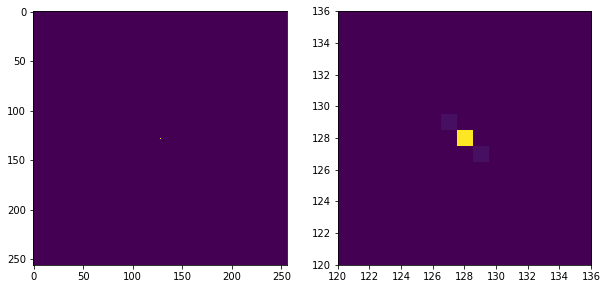

In [22]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

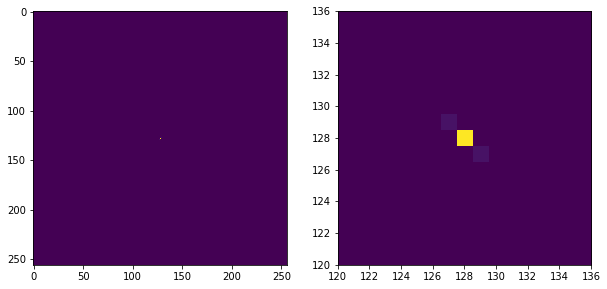

In [23]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [24]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 3.20e+01/0.00e+00/2.31e-01/4.98e-01/1.10e+04/64.3 peak at (0, 0)'

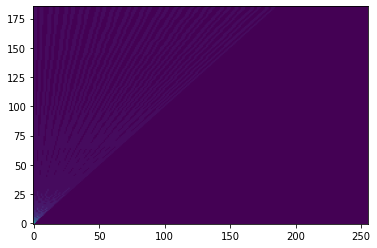

In [25]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

(664, 8, 256)
(5312, 256)


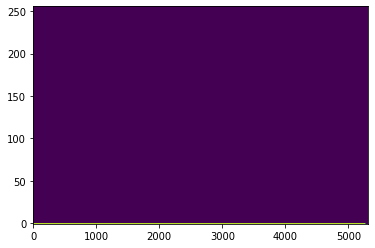

In [26]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')

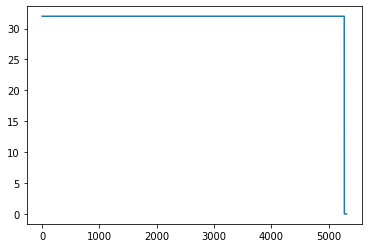

In [27]:
plot(d[:, 0])
 # Oh yeah, OK, this makes sense. It's 32 for all baselines because I made every UV = 1. IN practice, it won't be that neat.

# And what if I grid everything properly?

In [28]:
print(plan.baseline_shape) # nbl, nc, nt
values.input_scale = 1./16. # need this otherwise somewhere candidates overflow.

(190, 256, 256)


In [29]:
din = np.zeros(plan.baseline_shape, dtype=np.complex64)
din[:, :, 0] = 1 # making this 32 overflows the FDMT


In [30]:
import craft.craco
fast_baseline2uv = craft.craco.FastBaseline2Uv(plan, conjugate_lower_uvs=True)
uv_shape     = (plan.nuvrest, plan.nt, plan.ncin, plan.nuvwide)
uv_out  = np.zeros(uv_shape, dtype=np.complex64)
fast_baseline2uv(din, uv_out)

In [31]:
print(uv_out.shape)

(659, 256, 32, 8)


In [32]:
p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
print(p.inbuf.nparr.mean())

0.001126232928679818


In [33]:
p.inbuf.copy_to_device()

In [34]:
p.run(0, values).wait()

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


In [35]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 6.40e+01/0.00e+00/4.62e-01/9.96e-01/2.20e+04/64.3 peak at (0, 0)'

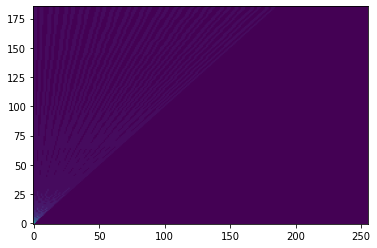

In [36]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

(664, 8, 256)
(5312, 256)


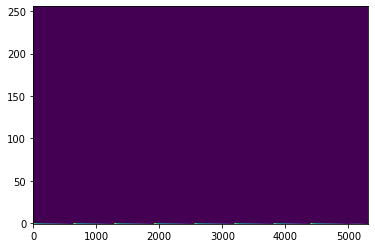

In [37]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')

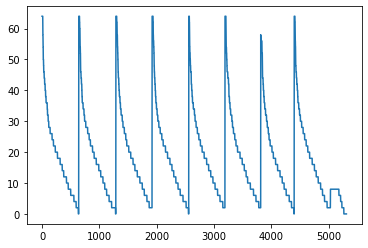

In [38]:
plot(d[:, 0])
# OK so this crazy shape is because of how we're inefficiently packing channels into UV points

In [39]:
cands = p.get_candidates()
print(len(cands))

42


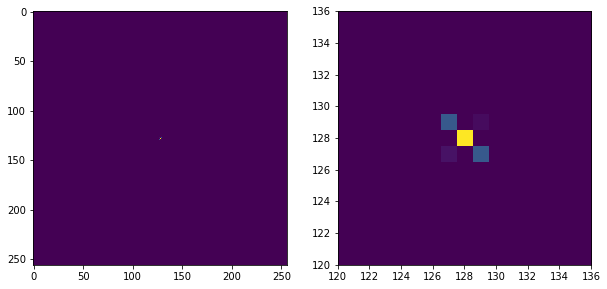

In [40]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [41]:
print_candidates(cands, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk

47.4	128	128	0		0	0	0
13.0	129	129	1		1	0	0
23.3	127	129	0		0	0	0
23.3	129	127	0		0	0	0
12.5	127	127	0		0	0	0
33.3	128	128	1		1	1	0
16.4	127	129	1		1	1	0
16.4	129	127	1		1	1	0
10.1	127	127	0		0	1	0
25.9	128	128	4		4	2	0
12.9	127	129	1		1	2	0
12.9	129	127	1		1	2	0
16.3	128	128	7		8	2	0
30.8	128	128	3		4	3	0
14.7	127	129	3		4	3	0
14.7	129	127	3		4	3	0
23.5	128	128	7		8	3	0
11.0	127	129	7		8	3	0
11.0	129	127	7		8	3	0
28.8	128	128	4		5	4	0
13.8	127	129	4		5	4	0
13.8	129	127	4		5	4	0
22.6	128	128	7		8	4	0
10.8	127	129	7		8	4	0
10.8	129	127	7		8	4	0
23.5	128	128	5		6	5	0
11.5	127	129	5		6	5	0
11.5	129	127	5		6	5	0
19.9	128	128	7		8	5	0
20.8	128	128	5		6	6	0
10.2	127	129	5		6	6	0
10.2	129	127	5		6	6	0
18.3	128	128	7		8	6	0
19.1	128	128	6		7	7	0
17.5	128	128	7		8	7	0
14.6	128	128	6		7	8	0
15.4	128	128	7		8	8	0
14.5	128	128	6		7	9	0
16.6	128	128	5		8	9	0
13.2	128	128	3		7	10	0
14.3	128	128	5		8	10	0
11.4	128	128	5		9	11	0


# How about a DM pulse?

In [42]:
from craft import simfrb

In [66]:
dm = 50
toff = 100
tsamp = 1.7
frb = simfrb.mkfrb_fdmt(plan.fmin/1e9, plan.foff/1e9, plan.nf, tsamp, dm, toffset=toff, ntimes=plan.nt)

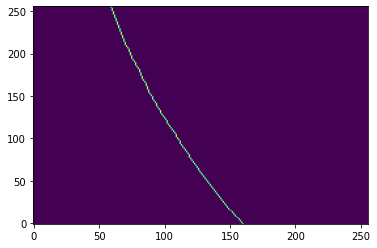

In [67]:
imshow(frb.T, aspect='auto', origin='lower')

In [68]:
din[:] = 0
print(din.shape, frb.shape)
din[:] = frb.T
fast_baseline2uv(din, uv_out)
assert din.sum() == uv_out.sum(), 'baseline2uv didnt conserve energy'

(190, 256, 256) (256, 256)


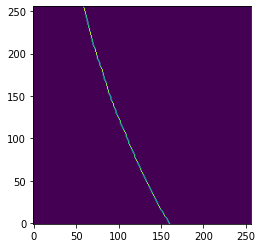

In [69]:
imshow(din[0,:,:].real, origin='lower')

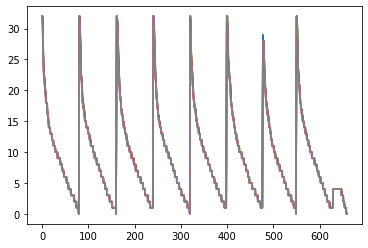

In [70]:
plot(uv_out.sum(axis=1).sum(axis=1).real)

(659, 256, 32, 8) (48640+0j) (48640+0j)


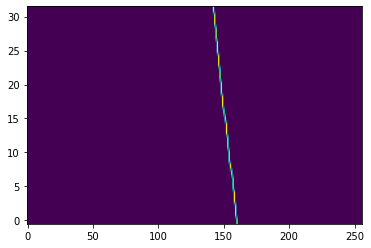

In [71]:
print(uv_out.shape, uv_out.sum(), din.sum())
imshow(uv_out[1,:,:,0].real.T, aspect='auto', origin='lower')

In [72]:
# This one seems to hang when together with the 3 cells below. Let's space it out.
p.clear_buffers(values)


INFO:root:Clearing mainbuf data NBLK=11
INFO:root:Mainbuf cleared. Clearing input
INFO:root:Input cleared. Running pipeline
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=1 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=2 nuv=5272 nparallel_uv=2636 nurest=65

In [73]:

p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.copy_to_device()
values.run_fdmt = True
values.run_image = True
values.threshold = 10


In [74]:
p.run(0, values).wait()

INFO:craco.search_pipeline:
Configuration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:root:Running fdmt
INFO:root:fdmt complete
INFO:root:Candidates cleared
INFO:root:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


In [76]:
cands = p.get_candidates()
print_candidates(cands, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk

10.1	128	128	7		158	88	0
11.1	128	128	7		158	89	0
13.3	128	128	7		157	90	0
12.3	128	128	7		158	91	0
11.1	128	128	7		160	91	0
14.6	128	128	7		159	92	0
12.2	128	128	7		160	92	0
16.8	128	128	6		159	93	0
15.9	128	128	7		160	93	0
17.0	128	128	6		159	94	0
16.1	128	128	7		160	94	0
18.4	128	128	5		159	95	0
17.6	128	128	6		160	95	0
18.5	128	128	4		159	96	0
19.1	128	128	5		160	96	0
18.2	128	128	3		159	97	0
20.5	128	128	4		160	97	0
10.1	127	129	4		160	97	0
10.1	129	127	4		160	97	0
16.2	128	128	1		158	98	0
23.4	128	128	3		160	98	0
11.6	127	129	3		160	98	0
11.6	129	127	3		160	98	0
17.8	128	128	1		159	99	0
26.4	128	128	2		160	99	0
13.0	127	129	2		160	99	0
13.0	129	127	2		160	99	0
18.9	128	128	0		159	100	0
29.0	128	128	1		160	100	0
14.2	127	129	1		160	100	0
14.2	129	127	1		160	100	0
31.8	128	128	1		161	101	0
15.6	127	129	1		161	101	0
15.6	129	127	1		161	101	0
10.2	127	127	0		160	101	0
26.6	128	128	2		162	102	0
13.1	127	129	2		162	102	0
13.1	129	127	2		162	102	

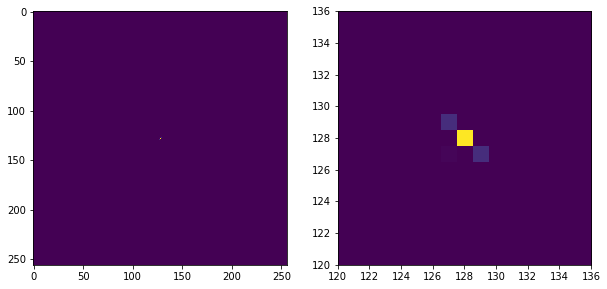

In [77]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

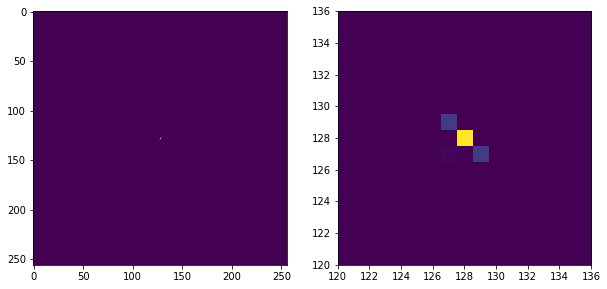

In [78]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [79]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 4.80e+01/0.00e+00/4.00e-01/1.13e+00/1.90e+04/42.6 peak at (17, 159)'

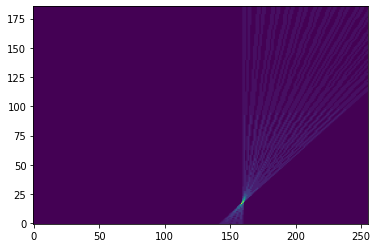

In [80]:
print(mainbuf.shape)
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)